# GPU Accelerated Deep Learning for Time Series Forecasting 
## Saturn Cloud + Modeltime GluonTS using NVIDIA GPUs

This is a short demonstration that showcases the capability of combining Modeltime GluonTS with NVIDIA GPUs using the Saturn Cloud Platform. 

In [56]:
# Point to Python
Sys.setenv(GLUONTS_PYTHON = '/opt/conda/bin/python')

# Modeling
library(modeltime)
library(tidymodels)

# GluonTS Deep Learning
library(modeltime.gluonts)

# Core + Time Series
library(tidyverse)
library(timetk)

# ggplot printing
options(repr.plot.width=16, repr.plot.height=8)


In [3]:
# Check GluonTS is activated
is_gluonts_activated()

[1] TRUE

## Data

In [4]:
# Load the walmart dataset from timetk

head(walmart_sales_weekly)

id,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
<fct>,<dbl>,<dbl>,<date>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1_1,1,1,2010-02-05,24924.50,FALSE,A,151315,42.31,2.572,NA,NA,NA,NA,NA,211.0964,8.106
1_1,1,1,2010-02-12,46039.49,TRUE,A,151315,38.51,2.548,NA,NA,NA,NA,NA,211.2422,8.106
1_1,1,1,2010-02-19,41595.55,FALSE,A,151315,39.93,2.514,NA,NA,NA,NA,NA,211.2891,8.106
1_1,1,1,2010-02-26,19403.54,FALSE,A,151315,46.63,2.561,NA,NA,NA,NA,NA,211.3196,8.106
1_1,1,1,2010-03-05,21827.90,FALSE,A,151315,46.50,2.625,NA,NA,NA,NA,NA,211.3501,8.106
1_1,1,1,2010-03-12,21043.39,FALSE,A,151315,57.79,2.667,NA,NA,NA,NA,NA,211.3806,8.106


## Split the Series into Train/Test

In [33]:
# Create time series split
FORECAST_HORIZON <- 28

splits <- walmart_sales_weekly %>%
    select(id, Date, Weekly_Sales) %>%
    time_series_split(assess = FORECAST_HORIZON, cumulative = TRUE)

splits

Using date_var: Date

Data is not ordered by the 'date_var'. Resamples will be arranged by `Date`.

Overlapping Timestamps Detected. Processing overlapping time series together using sliding windows.



<Analysis/Assess/Total>
<805/196/1001>

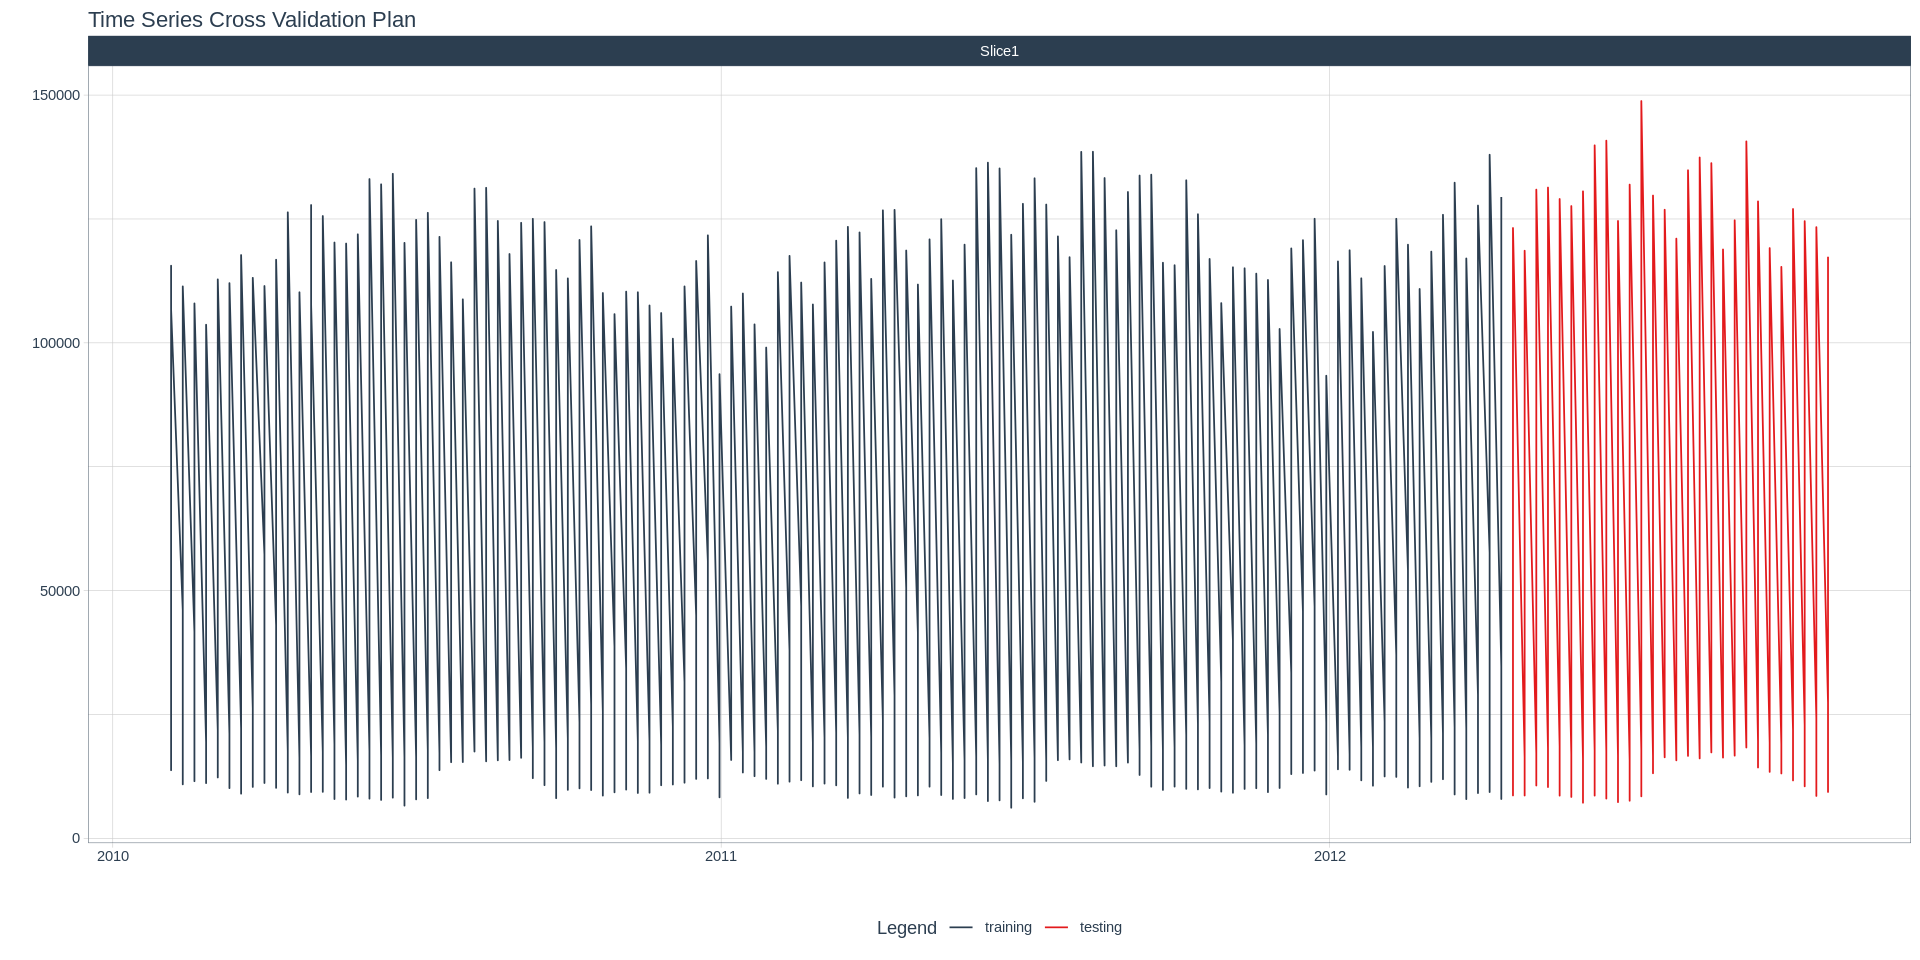

In [57]:
# Visualize the split
splits %>%
    tk_time_series_cv_plan() %>%
    plot_time_series_cv_plan(.date_var = Date, .value = Weekly_Sales, .interactive = FALSE)
    

## Training

- Fit a GluonTS DeepAR Model
- Using the Nvidia GPU

In [28]:
t0 <- Sys.time()
model_fit_deepar <- deep_ar(
  id                    = "id",
  freq                  = "W",
  prediction_length     = 28,
  lookback_length       = 36,
  epochs                = 3, 
  num_batches_per_epoch = 50,
  learn_rate            = 0.01,
  num_layers            = 2,
  num_cells             = 80,
  dropout               = 0.10,
  scale                 = TRUE      
) %>%
  set_engine("gluonts_deepar") %>%
  fit(Weekly_Sales ~ Date + id, training(splits))

t1 <- Sys.time()
t1-t0



Time difference of 21.85289 secs

In [29]:
model_fit_deepar

parsnip model object

Fit time:  21.6s 
DeepAR
--------
Model: <gluonts.mx.model.predictor.RepresentableBlockPredictor>

gluonts.model.deepar._network.DeepARPredictionNetwork(cardinality=[1], cell_type="lstm", context_length=36, distr_output=gluonts.mx.distribution.student_t.StudentTOutput(), dropout_rate=0.1, dropoutcell_type="ZoneoutCell", dtype=numpy.float32, embedding_dimension=[1], history_length=193, lags_seq=[1, 2, 3, 4, 5, 6, 7, 8, 12, 51, 52, 53, 103, 104, 105, 155, 156, 157], num_cells=80, num_layers=2, num_parallel_samples=100, prediction_length=28, scaling=True)

## Calibrate and Accuracy

In [39]:
calibration_tbl <- modeltime_table(
    model_fit_deepar
) %>%
    modeltime_calibrate(testing(splits)) 

calibration_tbl %>% modeltime_accuracy()

.model_id,.model_desc,.type,mae,mape,mase,smape,rmse,rsq
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,DEEPAR,Test,5643.828,11.20497,0.1652429,10.75544,9343.138,0.9494945


## Forecast the Test Set

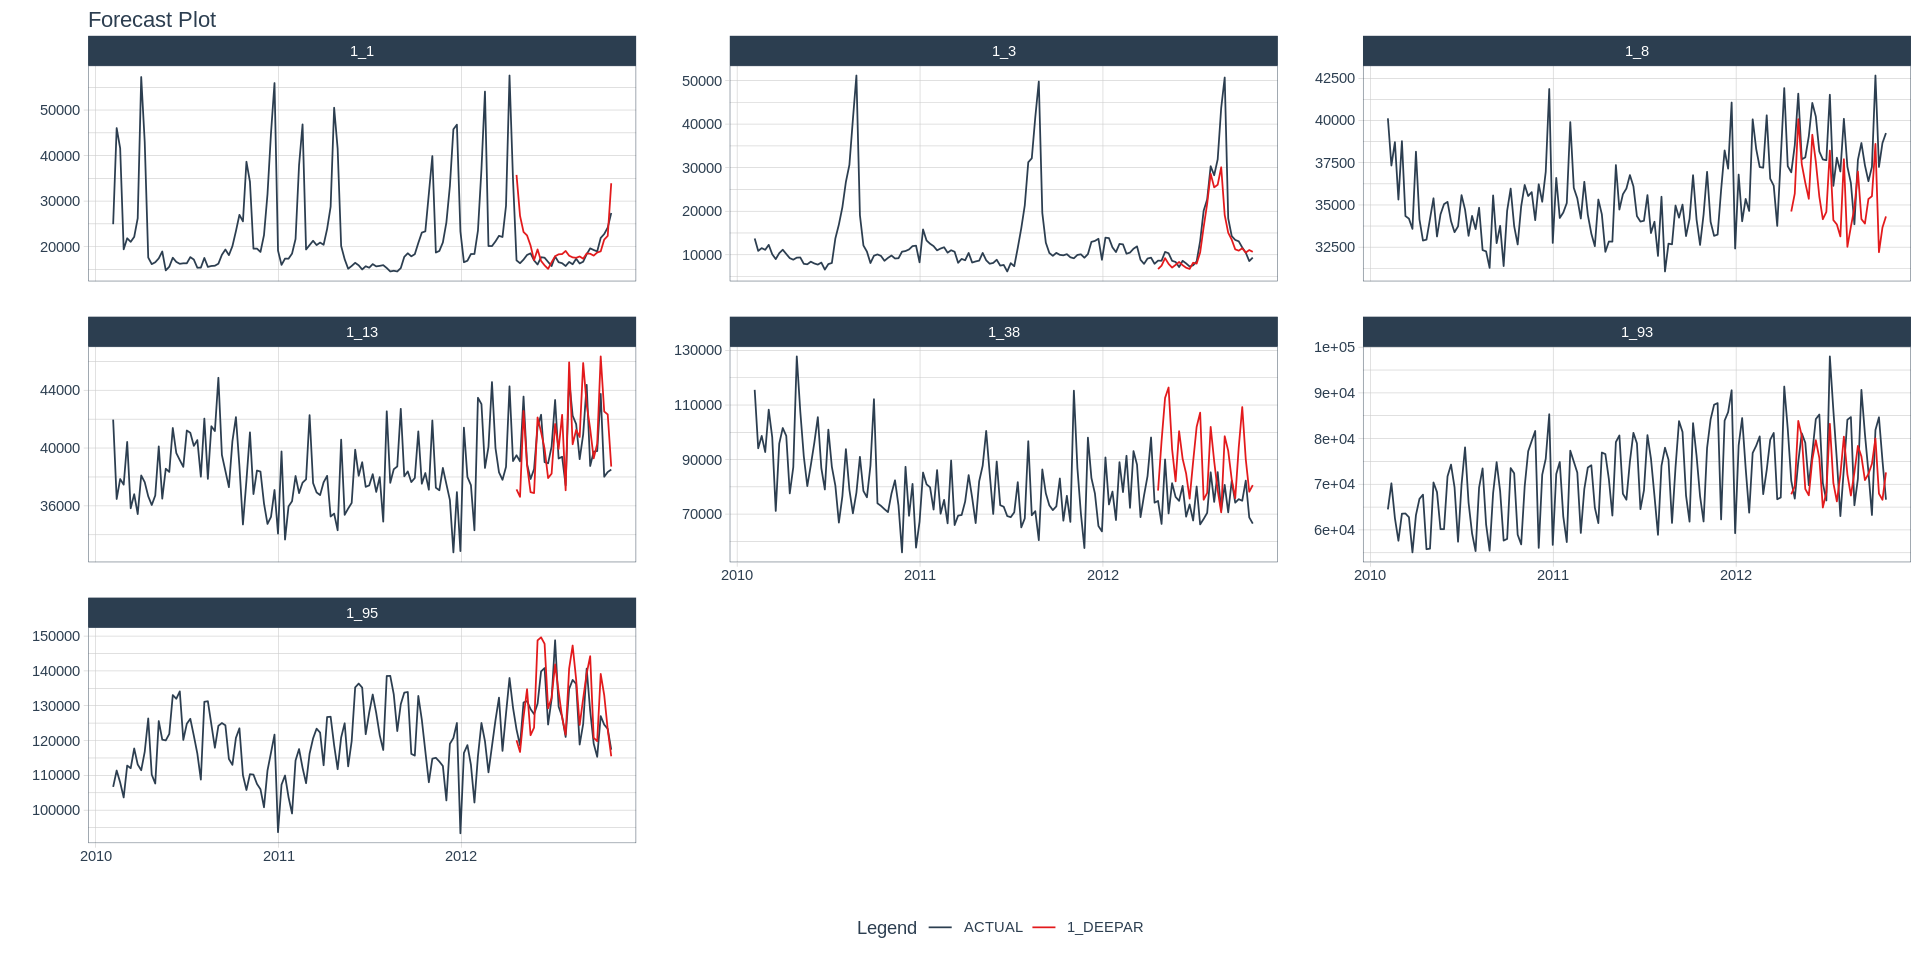

In [58]:
calibration_tbl %>%
    modeltime_forecast(
        new_data    = testing(splits), 
        actual_data = walmart_sales_weekly,
        keep_data   = TRUE
    ) %>%
    group_by(id) %>%
    plot_modeltime_forecast(.facet_ncol = 3, .interactive = F, .conf_interval_show = F)

## Refit and Forecast the Future

In [38]:
# Make the Future Dataset to be Forecast
future_data_tbl <- walmart_sales_weekly %>%
    select(id, Date, Weekly_Sales) %>%
    group_by(id) %>%
    future_frame(
        `.date_var` = Date, 
        `.length_out` = FORECAST_HORIZON, 
        `.bind_data` = TRUE
    ) %>%
    ungroup() %>%
    filter(is.na(Weekly_Sales))

future_data_tbl %>% head()

id,Date,Weekly_Sales
<fct>,<date>,<dbl>
1_1,2012-11-02,NA
1_1,2012-11-09,NA
1_1,2012-11-16,NA
1_1,2012-11-23,NA
1_1,2012-11-30,NA
1_1,2012-12-07,NA


In [44]:
# Refit the model on the full set of data
t0 <- Sys.time()

refit_tbl <- calibration_tbl %>%
    modeltime_refit(data = bind_rows(training(splits), testing(splits)))

t1 <- Sys.time()
t1-t0



Time difference of 11.933 secs

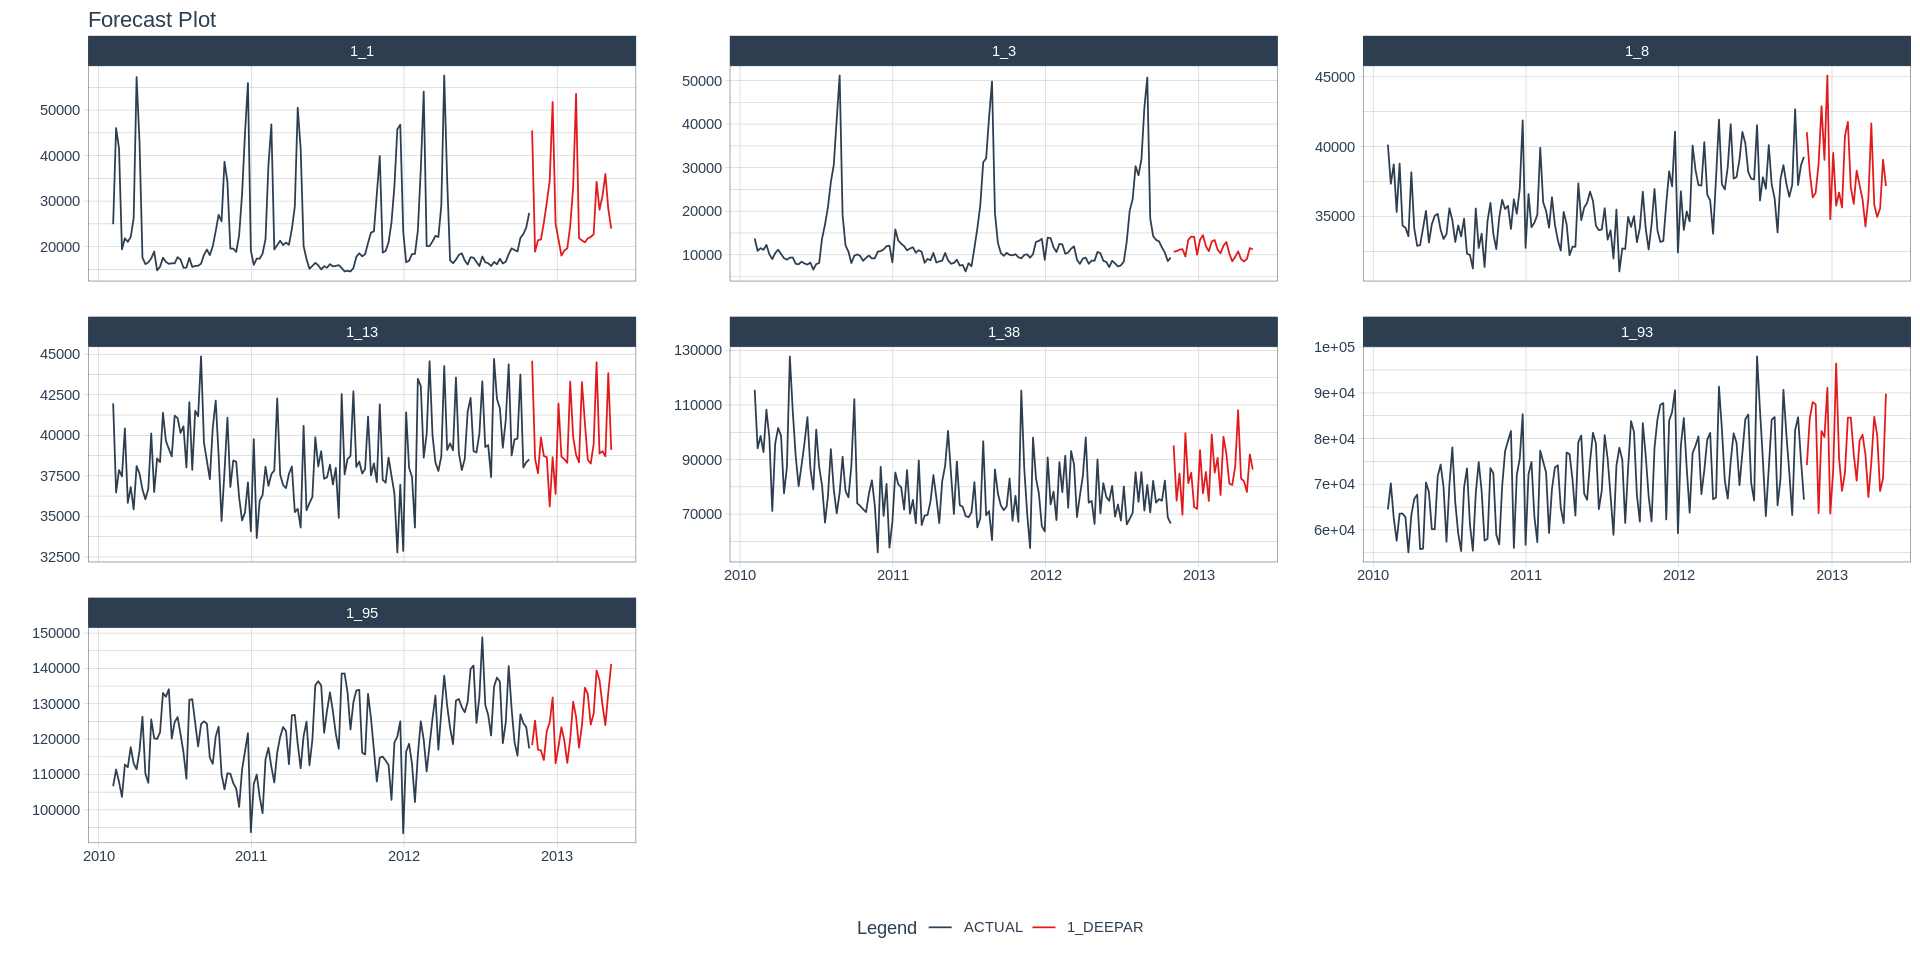

In [59]:
# Forecast and Plot
refit_tbl %>%
    modeltime_forecast(
        new_data    = future_data_tbl, 
        actual_data = walmart_sales_weekly,
        keep_data   = TRUE
    ) %>%
    group_by(id) %>%
    plot_modeltime_forecast(.facet_ncol = 3, .interactive = F, .conf_interval_show = F)